In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path
import shutil
import gzip

from matplotlib import pyplot as plt
%matplotlib inline

# Download ForestCoverType dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
dataset_name = 'forest-cover-type'
tmp_out = Path('./data/'+dataset_name+'.gz')
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [3]:
# check if using cuda
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(f'device: {device}')

device: cuda


In [4]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, tmp_out.as_posix())
    with gzip.open(tmp_out, 'rb') as f_in:
        with open(out, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

File already exists.


# Load data and split
Same split as in original paper

In [5]:
target = "Covertype"

bool_columns = [
    "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3",
    "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4",
    "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9",
    "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14",
    "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19",
    "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24",
    "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29",
    "Soil_Type30", "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34",
    "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39",
    "Soil_Type40"
]

int_columns = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

feature_columns = (
    int_columns + bool_columns + [target])

In [6]:
# train = pd.read_csv(out, header=None, names=feature_columns)
train = pd.read_csv('data/forest-cover-type.csv', header=None, names=feature_columns)

n_total = len(train)

# Train, val and test split follows
# Rory Mitchell, Andrey Adinets, Thejaswi Rao, and Eibe Frank.
# Xgboost: Scalable GPU accelerated learning. arXiv:1806.11248, 2018.

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [7]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

# Define categorical features for categorical embeddings

In [8]:
# This is a generic pipeline but actually no categorical features are available for this dataset

unused_feat = []

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


# Network parameters

In [9]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

d:\_workspace\tabnet\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


# Training

In [10]:
if os.getenv("CI", False):
# Take only a subsample to run CI
    X_train = train[features].values[train_indices][:1000,:]
    y_train = train[target].values[train_indices][:1000]
else:
    X_train = train[features].values[train_indices]
    y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [11]:
# max_epochs = 100 if not os.getenv("CI", False) else 2
max_epochs = 10 if not os.getenv("CI", False) else 2

In [12]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.2)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=100,
    batch_size=16384, virtual_batch_size=256,
    augmentations=aug
) 

epoch 0  | loss: 1.21295 | train_accuracy: 0.2219  | valid_accuracy: 0.22117 |  0:00:38s
epoch 1  | loss: 0.81039 | train_accuracy: 0.17631 | valid_accuracy: 0.17601 |  0:02:05s
epoch 2  | loss: 0.75586 | train_accuracy: 0.13824 | valid_accuracy: 0.13566 |  0:02:45s
epoch 3  | loss: 0.72334 | train_accuracy: 0.11508 | valid_accuracy: 0.11507 |  0:02:56s
epoch 4  | loss: 0.69824 | train_accuracy: 0.0931  | valid_accuracy: 0.09254 |  0:03:08s
epoch 5  | loss: 0.6877  | train_accuracy: 0.07553 | valid_accuracy: 0.07516 |  0:03:19s
epoch 6  | loss: 0.67907 | train_accuracy: 0.07468 | valid_accuracy: 0.07348 |  0:03:30s
epoch 7  | loss: 0.67335 | train_accuracy: 0.11902 | valid_accuracy: 0.11834 |  0:04:24s
epoch 8  | loss: 0.67089 | train_accuracy: 0.15468 | valid_accuracy: 0.15526 |  0:05:15s
epoch 9  | loss: 0.66028 | train_accuracy: 0.1973  | valid_accuracy: 0.19752 |  0:05:26s
Stop training because you reached max_epochs = 10 with best_epoch = 0 and best_valid_accuracy = 0.22117


d:\_workspace\tabnet\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


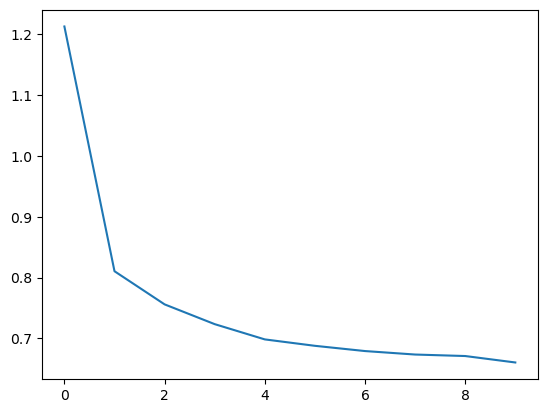

In [13]:
# plot losses
plt.plot(clf.history['loss'])

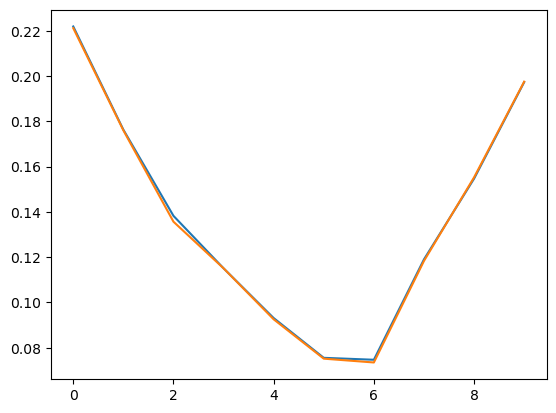

In [14]:
# plot accuracy
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

In [15]:
# print(train_embeddings.shape)

### Predictions


In [16]:
# To get final results you may need to use a mapping for classes 
# as you are allowed to use targets like ["yes", "no", "maybe", "I don't know"]

preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

preds = clf.predict_proba(X_test)

y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

BEST VALID SCORE FOR forest-cover-type : 0.2211673131659965
FINAL TEST SCORE FOR forest-cover-type : 0.22263624863385628


In [17]:
# or you can simply use the predict method

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

FINAL TEST SCORE FOR forest-cover-type : 0.22263624863385628


# Save and load Model

In [18]:
# save state dict
saved_filename = clf.save_model('test_model')

Successfully saved model at test_model.zip


In [19]:
# define new model and load save parameters
loaded_clf = TabNetClassifier()
# loaded_clf.load_model(saved_filename)
loaded_clf.load_model('test_model.zip')

d:\_workspace\tabnet\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [24]:
# 1. Sample the train dataset in a class-balanced manner
train_balanced = train.groupby(target, group_keys=False).apply(lambda x: x.sample(n=500, random_state=42))

# 2. Extract embeddings from the appropriate layer of the model for the balanced samples
X_train_balanced = train_balanced[features].values
y_train_balanced = train_balanced[target].values

In [25]:
# Extract embeddings for the balanced samples
embeddings = clf.extract_embeddings(X_train_balanced)

# Verify the shape of the embeddings
print("Embeddings shape:", embeddings.shape)
print("Number of samples:", len(y_train_balanced))

Embeddings shape: (3500, 54)
Number of samples: 3500


In [26]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1)
tsne_embeddings = tsne.fit_transform(embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3500 samples in 0.001s...
[t-SNE] Computed neighbors for 3500 samples in 0.088s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3500
[t-SNE] Computed conditional probabilities for sample 2000 / 3500
[t-SNE] Computed conditional probabilities for sample 3000 / 3500
[t-SNE] Computed conditional probabilities for sample 3500 / 3500
[t-SNE] Mean sigma: 188.844690
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.802292
[t-SNE] KL divergence after 1000 iterations: 0.901034


iVAT Processing: 100%|██████████| 3499/3499 [00:00<00:00, 16780.13it/s]


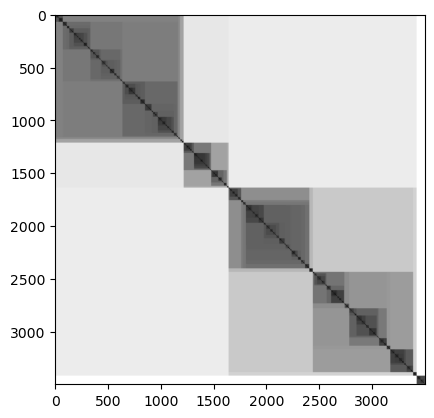

In [27]:
from VAT_library.iVAT import iVAT
from scipy.spatial.distance import cdist

pairwise_dist = cdist(tsne_embeddings, tsne_embeddings)

RiV, RV, reordering_mat = iVAT(pairwise_dist)

plt.imshow(RiV, cmap='gray')
plt.savefig('tabnet_test.png')

In [ ]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_y_pred = np.vectorize(preds_mapper.get)(np.argmax(loaded_preds, axis=1))

loaded_test_acc = accuracy_score(y_pred=loaded_y_pred, y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_acc}")

NameError: name 'X_test' is not defined

In [ ]:
assert(test_acc == loaded_test_acc)

# Global explainability : feat importance summing to 1

In [25]:
clf.feature_importances_

array([1.38007383e-01, 5.40572371e-02, 2.08481290e-05, 3.04097697e-02,
       4.66621519e-02, 5.57399268e-02, 2.18767870e-02, 3.26327055e-02,
       0.00000000e+00, 9.47937260e-03, 6.54386397e-02, 2.31019880e-02,
       1.63795704e-02, 5.52711972e-02, 2.18987404e-05, 7.51643102e-03,
       1.72224614e-04, 3.52424343e-03, 7.82578043e-03, 3.29549723e-03,
       2.23850224e-02, 1.13340070e-02, 6.85158329e-04, 5.21424728e-03,
       1.37747461e-03, 8.14274704e-02, 1.63934238e-02, 7.89559229e-03,
       1.38438038e-03, 6.21978586e-03, 8.96083329e-05, 1.35931808e-02,
       1.60578096e-02, 1.54808904e-04, 1.73355280e-02, 2.51950511e-02,
       1.75935974e-02, 1.05326157e-02, 6.58263802e-03, 5.28765037e-04,
       1.39080316e-03, 2.88413796e-03, 1.96212968e-02, 5.26950615e-03,
       3.31341900e-03, 4.12516919e-04, 1.77276570e-02, 2.70825486e-03,
       1.47649604e-04, 2.12178995e-02, 2.61320131e-04, 2.07515766e-02,
       2.33587293e-02, 4.75214155e-02])

# Local explainability and masks

In [26]:
explain_matrix, masks = clf.explain(X_test)

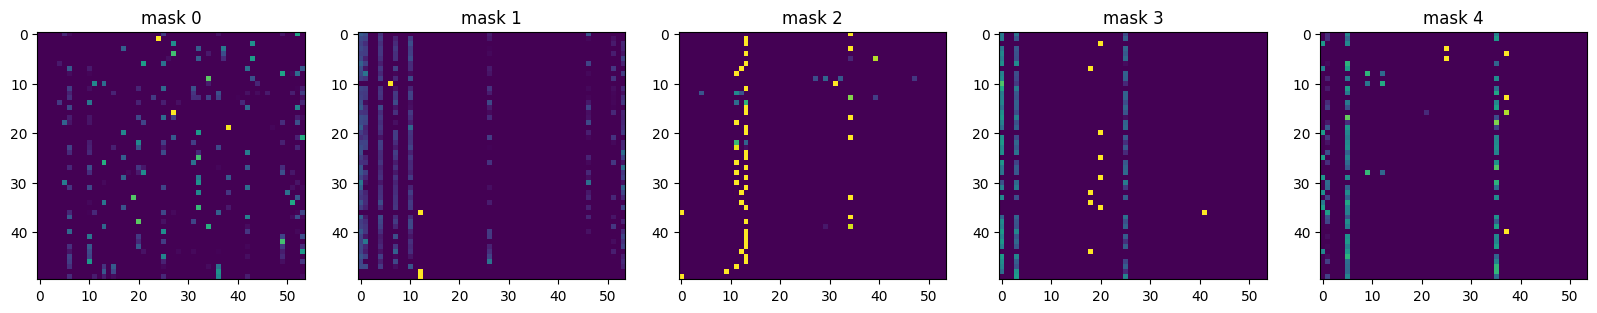

In [27]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

# XGB

In [28]:
n_estimators = 1000 if not os.getenv("CI", False) else 20

In [33]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=n_estimators,
    verbosity=0,
    silent=None,
    objective="multi:softmax",
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,
    classes=[1,2,3,4,5,6,7])

clf_xgb.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=40,
            verbose=10)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5 6], got [1 2 3 4 5 6 7]

In [ ]:
preds_valid = np.array(clf_xgb.predict_proba(X_valid, ))
valid_acc = accuracy_score(y_pred=np.argmax(preds_valid, axis=1) + 1, y_true=y_valid)
print(valid_acc)

preds_test = np.array(clf_xgb.predict_proba(X_test))
test_acc = accuracy_score(y_pred=np.argmax(preds_test, axis=1) + 1, y_true=y_test)
print(test_acc)